<img src="images/nyp_ago_logo.png" width='400'/>

# Predict Fraudulent Firm

In this exercise, we will try to build a classification model that can help auditor to predict the fraudulent firm on the basis of present and historical risk factors

The following dataset is based on the research work done as a case study of an external government audit company which is also the external auditor of government firms of India. During audit-planning, auditors examine the business of different government offices. There are total 777 firms data from 46 different cities of a state that are listed by the auditors for targeting the next field-audit work. 

Below is partial description of the differenet columns in the dataset (many description are missing for the various columns in the Kaggle site as well as the original UCI Machine Learning Repository).

|Field|Description|
|----|----|
|Sector_score|Historical risk score value of the target-unit using analytical procedure|
|LOCATION_ID|Unique ID of the city/province|
|PARA_A|Discrepancy found in the planned expenditure of inspection and summary report A in Rs (in crore)|
|PARA_B|Discrepancy found in the unplanned expenditure of inspection and summary report B in Rs (in crore)|
|Total|Total amount of discrepancy found in other reports Rs (in crore)|
|numbers|Historical discrepancy score|
|Money_Value|Amount of money involved in misstatements in the past audits|
|Audit_Risk|Total risk score using analytical procedure|
|Risk|Risk class assigned to an audit-case (Target feature)|


1. Sector_score- Historical risk score value of the target-unit using analytical procedure
2. LOCATION_ID- Unique ID of the city/province.
3. PARA_A- Discrepancy found in the planned expenditure of inspection and summary report A in Rs (in crore).
4. PARA_B- Discrepancy found in the unplanned expenditure of inspection and summary report B in Rs (in crore).
5. TOTAL- Total amount of discrepancy found in other reports Rs (in crore).
6. numbers- Historical discrepancy score
7. Money_Value- Amount of money involved in misstatements in the past audits.
8. Audit_Risk- Total risk score using analytical procedure
9. Risk- Risk Class assigned to an audit-case. (Target label)


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
plt.style.use('fivethirtyeight')

## Read the Data

In [2]:
df = pd.read_csv("data/audit_data.csv")

Let's find out some information about the data, such the columns and its datatype. We can see that all columns are numeric except the LOCATION_ID. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sector_score    776 non-null    float64
 1   LOCATION_ID     776 non-null    object 
 2   PARA_A          776 non-null    float64
 3   Score_A         776 non-null    float64
 4   Risk_A          776 non-null    float64
 5   PARA_B          776 non-null    float64
 6   Score_B         776 non-null    float64
 7   Risk_B          776 non-null    float64
 8   TOTAL           776 non-null    float64
 9   numbers         776 non-null    float64
 10  Score_B.1       776 non-null    float64
 11  Risk_C          776 non-null    float64
 12  Money_Value     775 non-null    float64
 13  Score_MV        776 non-null    float64
 14  Risk_D          776 non-null    float64
 15  District_Loss   776 non-null    int64  
 16  PROB            776 non-null    float64
 17  RiSk_E          776 non-null    flo

**Exercise**

Are there any missing values? Write code to check for missing value and if so, how should we handle this missing value? 

<details><summary>Click here for solution</summary>

```python

df.isna().sum()
df.dropna(axis=0, inplace=True)
```
<br/>
There is missing value for the Money_Value column. There are few ways to handle missing value, e.g. throw away the row that contains the missing value, or throw away the column that has the missing value, or impute the missing value.  In this case, since we only have one missing value for one record, we should not throw away the entire column.  We can either throw away the row (record) or impute the value. In our case, we just throw away the record.
</details>

In [4]:
## Write code here 

df.isna().sum()
df.dropna(axis=0, inplace=True)

## Exploratory Data Analysis

Before we start our EDA, it is good practice to set aside a test set, so that we only perform EDA on the train set, to prevent any 'data snooping'. 

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Risk'], random_state=42)

**Exercise**

Let's plot the distribution of the target label 'Risk'. Is there any obvious class imbalance?

<p>
<details><summary>Click here for answer</summary>

```python
sns.countplot(x = df['Risk'], label = "Count")
```
<br/>

There are 471 non-risk vs 305 risk class, so the data is not really imbalanced. 
</details>

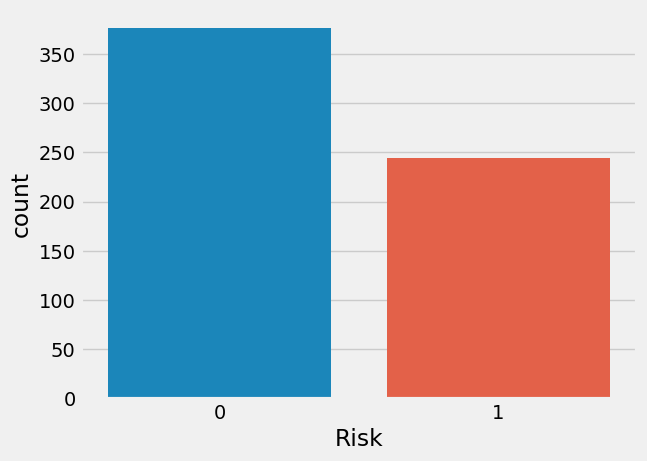

In [6]:
sns.countplot(x = df_train['Risk'], label = "Count")
plt.show()

One quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. You can do so using the hist() method on the panda dataframe

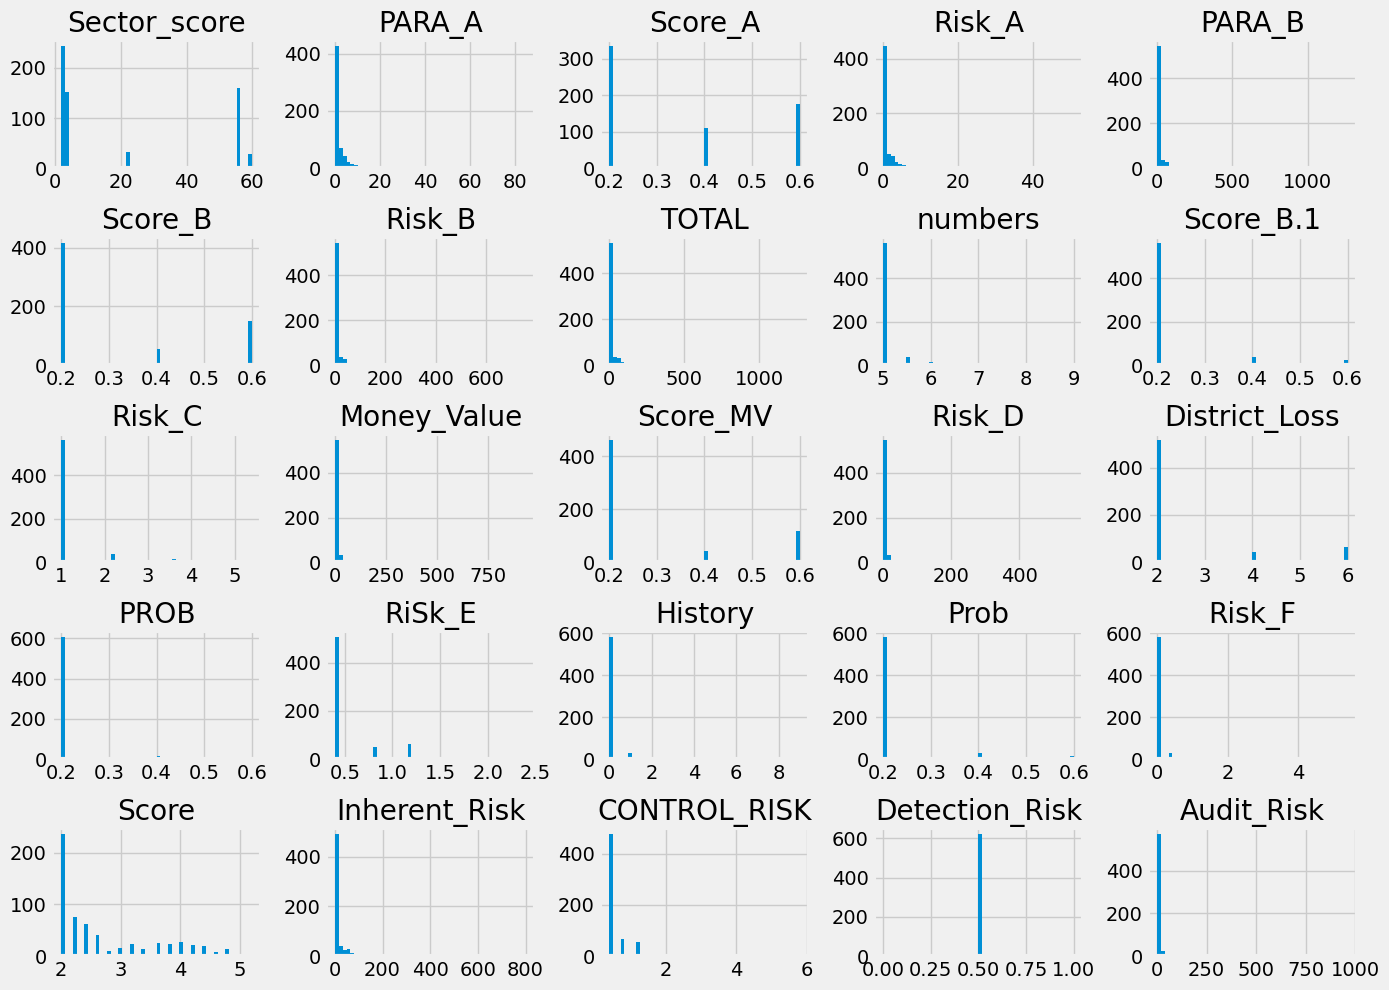

In [7]:
df_features = df_train.copy().drop('Risk', axis=1)
df_features.hist(bins=50, figsize=(14, 10))
plt.rc('font', size=10)
plt.tight_layout()
plt.show()

**Exercise** 

What do you notice about the 'Detection_Risk'? 

<details><summary>Click here for solution</summary>
<br/>
The 'Detection_Risk' seems to only have one. To confirm it, we can use value_counts() to find out.
<br/>
<br/>
    
```python
df_features['Detection_Risk'].value_counts()
```
    
</details>

In [8]:
df_features['Detection_Risk'].value_counts()

0.5    620
Name: Detection_Risk, dtype: int64

### Is there any redundant feature? 

From the description of the dataset, it is said that the TOTAL column is the total amount of discrepancy found in other reports PARA_A and PARA_B. This will introduce multicollinearity in our model and should be avoided. Let's find out if this is the case.

We will first create a column 'TOTAL_2' that is the sum of both PARA_A and PARA_B values. 

In [9]:
df_features['TOTAL_2'] = df[['PARA_A', 'PARA_B']].sum(axis=1)

Let's print out those rows which have different TOTAL from the sum of PARA_A and PARA_B (i.e. TOTAL_2). 

In [10]:
df_features.loc[(df_features['TOTAL_2'] != df_features['TOTAL'])][['TOTAL', 'TOTAL_2']]

,TOTAL,TOTAL_2
494,0.00,20.65
462,1.68,1.68
306,0.90,0.90
773,0.28,0.28
126,75.28,75.28
...,...,...
530,1.93,1.93
322,2.11,2.11
401,10.36,10.36
57,24.87,24.87


What do you observe?  Seems that there are total of 106 rows that have different TOTAL and TOTAL_2.  But on closer look, they have the same values!! What happened? 
Turn out that comparing two floating point values are problematic due to internal precision error when representing floating number. We can round the floating point numbers to certain fixed number of precision using `df.round()` and then compare them or we can use `np.isclose()`. 

Let's compare again after rounding the TOTAL and TOTAL_2 to 9 decimal places.

In [11]:
df_features.loc[(df_features['TOTAL_2'].round(9) != df_features['TOTAL'].round(9))][['TOTAL', 'TOTAL_2']]

,TOTAL,TOTAL_2
494,0.0,20.65
489,0.0,3.95


We see that we only 2 rows that are gives a different total. This may be due to data entry error. We can go ahead and drop 'TOTAL' without much problem.

#### Check correlation

**Exercise** 

We can try to find out how the (numerical) features correlate with the target, by using Pearson coefficient. This can be done with panda dataframe `corrwith()`. 
Sort the correlation coefficients in descending order.

<details><summary>Click here for solution</summary>

```python 

df.corrwith(df['Risk']).sort_values(ascending=False)
```
</details>   

In [12]:
df_train.corrwith(df_train['Risk']).sort_values(ascending=False)

Risk              1.000000
Score             0.792262
Score_MV          0.682248
Score_B           0.648066
Score_A           0.613836
RiSk_E            0.441434
District_Loss     0.434703
CONTROL_RISK      0.427885
Risk_A            0.373785
PARA_A            0.368265
Score_B.1         0.365636
Risk_C            0.354115
Inherent_Risk     0.343667
numbers           0.318187
Prob              0.300928
TOTAL             0.281604
PARA_B            0.247484
Risk_B            0.246093
Money_Value       0.244671
Risk_D            0.242109
History           0.240385
Risk_F            0.218096
Audit_Risk        0.215836
PROB              0.158158
Sector_score     -0.383766
Detection_Risk         NaN
dtype: float64

<Axes: title={'center': 'Correlation with Risk'}>

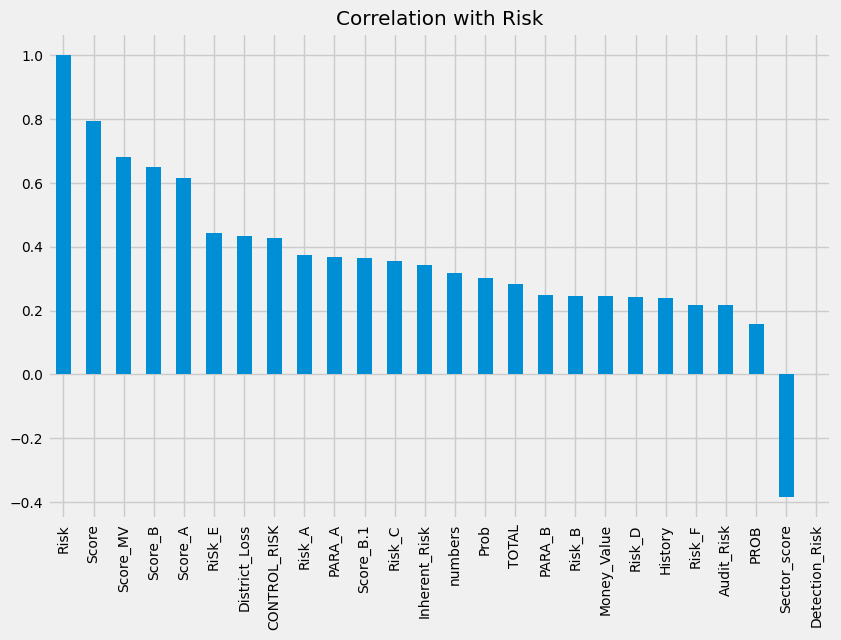

In [13]:
df_train.corrwith(df_train['Risk']).sort_values(ascending=False).plot.bar(title="Correlation with Risk", figsize=(9, 6))

If we are not usig Machine Learning, can we come up with a quick and simple rule-based classifier that predict the risk class of a firm (0 or 1)? 

From the correlation analysis above, we can see that the Score is most highly correlated with Risk (more than 0.78).  We can derive a simple rule-base classifier based just on the Score. If it exceeds certain threshold, then it is 'Risk', else it is 'No Risk'.  But how do we determine the threshold. To do this, it will be useful to look at how the values of Score is distributed for both 'Risk' class nad 'No Risk' class.
    


In [14]:
scores_Risk = df_train.loc[ df_train['Risk'] == 1 ].Score
scores_NoRisk = df_train.loc[ df_train['Risk'] == 0 ].Score

In [15]:
print('\nScores (Risk):\n', scores_Risk.describe())
print('\nScores (No Risk):\n', scores_NoRisk.describe())


Scores (Risk):
 count    244.000000
mean       3.573770
std        0.777439
min        2.200000
25%        2.950000
50%        3.600000
75%        4.200000
max        5.200000
Name: Score, dtype: float64

Scores (No Risk):
 count    376.000000
mean       2.155319
std        0.281564
min        2.000000
25%        2.000000
50%        2.000000
75%        2.200000
max        3.600000
Name: Score, dtype: float64


We can use boxplot to more easily identify the distribution of both Scores (Risk vs No Risk)

<Axes: >

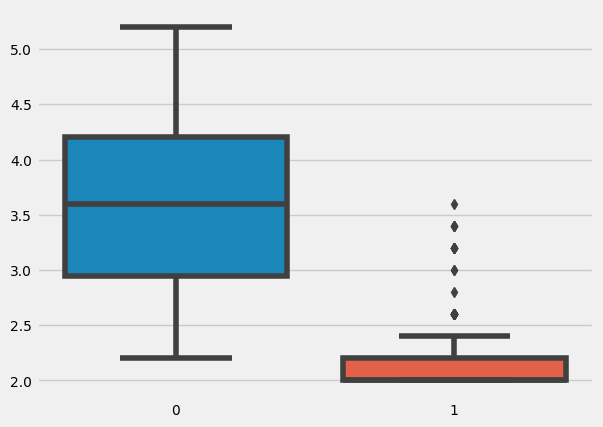

In [16]:
sns.boxplot([scores_Risk, scores_NoRisk])

**Exercise** 

What Score value should we use as a threshold to decide which is 'Risk' and 'No Risk'? Write code to determine the accuracy score for the selected threshold. 

<details><summary>Click here for solution</summary>
<br/>
    
```python
thresholds = [2.2, 2.3, 2.4, 2.5]

for threshold in thresholds: 
    preds = (df_test['Score'] >= threshold)
    acc = accuracy_score(df_test['Risk'], preds)
    print(f'accuracy score [threshold = {threshold}: {acc}')
```

<br/>
Based on the result, threshold of 2.3 and 2.4 give the highest accuracy score of 0.88)
</details>



In [17]:
## Complete the code 

thresholds = [2.2, 2.3, 2.4, 2.5]

for threshold in thresholds: 
    preds = (df_test['Score'] >= threshold)
    acc = accuracy_score(df_test['Risk'], preds)
    print(f'accuracy score [threshold = {threshold}: {acc}')

accuracy score [threshold = 2.2: 0.7419354838709677
accuracy score [threshold = 2.3: 0.8838709677419355
accuracy score [threshold = 2.4: 0.8838709677419355
accuracy score [threshold = 2.5: 0.8709677419354839


**Exercise** 

Instead of just using 'Score', we can also combine the value of other highly-correlated features such as 'Score_MV', 'Score_A', 'Score_B'.
Can you write the code to combine the values of these other features (e.g. use either `sum()` or `mean()`) and derive a threshold to use as a rule. 

The accuracy score attained by using simple rule-based comparison should be the baseline accuracy. Our ML should perform better than this baseline for it to be worthwhile.

## Data Preparation

Now we are done with our EDA.  Based on our EDA above, we can drop the columns "LOCATION_ID", "Detection_Risk" and "TOTAL". 

**Exercise**

Complete the code below to:

1. Drop the above-mentioned columns 
2. Split the dataset with stratified split
3. Scale the train set as well as test set.

<details><summary>Click here for solution</summary>

```python
df_prepared = df.drop(['LOCATION_ID', 'Detection_Risk', 'TOTAL'], axis=1)
```

</details>

In [18]:
## Complete the code 

df_prepared = df.drop(['LOCATION_ID', 'Detection_Risk', 'TOTAL'], axis=1)
X = df_prepared.drop('Risk', axis=1)
y = df_prepared['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 49)

In [19]:
df_prepared.isna().sum()

Sector_score     0
PARA_A           0
Score_A          0
Risk_A           0
PARA_B           0
Score_B          0
Risk_B           0
numbers          0
Score_B.1        0
Risk_C           0
Money_Value      0
Score_MV         0
Risk_D           0
District_Loss    0
PROB             0
RiSk_E           0
History          0
Prob             0
Risk_F           0
Score            0
Inherent_Risk    0
CONTROL_RISK     0
Audit_Risk       0
Risk             0
dtype: int64

### Feature Scaling 

**Exercise:** Apply standard scalar on the data.

Hints: Use `fit_transform()` on training data and use `transform` on testing data.

<p>
<details><summary>Click here for answer</summary>

```python
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train))
X_test_scaled = pd.DataFrame(sc_X.transform(X_test))
```

</details>

In [20]:
## Complete the code here 

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Modeling

Now we are ready to train our model. 

**Exercise**

We will first see how well a logistic regression model perform on our data by using Cross Validation, since our data is quite small.

<p>
<details><summary>Click here for answer</summary>

```python
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logi = LogisticRegression()
logi.fit(X_train_scaled, y_train)
```

</details>

In [21]:
## Complete the code 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lg_clf = LogisticRegression()
cross_val_score(lg_clf, X = X_train_scaled, y = y_train, cv=5, scoring = 'accuracy').mean()

0.9806451612903226

Based on the cross-validation accuracy scores, seems that our Logistic Regression (LR) model is pretty good. We will now train the LR using our full train set.

**Exercise**

Complete the code to train the LR with full X_train set and print the classification report on the X_test set. 

<details><summary>Click here for solution</summary>
<br/>

```python
lg_clf.fit(X_train, y_train)
y_preds = lg_clf.predict(X_test)
print(classification_report(y_test, y_preds))
```

</details>

In [22]:
## Complete the code 

lg_clf.fit(X_train, y_train)
y_preds = lg_clf.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        61

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



**Exercise:** 

Try to train another model using DecisionTreeClassifier. set the max_depth=3 to avoid overfitting. 
<p>
<details><summary>Click here for solution</summary>

```python
dt_clf = DecisionTreeClassifier(max_depth=3)
cross_val_score(dt_clf, X = X_train_scaled, y = y_train, cv=5, scoring = 'accuracy').mean()
dt_clf.fit(X_train, y_train)
y_preds = dt_clf.predict(X_test)
print(classification_report(y_test, y_preds))
```

</details>

In [23]:
## Complete the code below

dt_clf = DecisionTreeClassifier(max_depth=3)
cv_score = cross_val_score(dt_clf, X = X_train_scaled, y = y_train, cv=5, scoring = 'accuracy').mean()
print(f'CV Score for DecisionTreeClassifier: {cv_score}')
dt_clf.fit(X_train, y_train)
y_preds = dt_clf.predict(X_test)
print(classification_report(y_test, y_preds))

CV Score for DecisionTreeClassifier: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        61

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155

